# 🛒 Retail/E-commerce Recommendation System

- Feature engineering: product popularity, user profile, session & time features
- Data cleaning and transformation
- Models: Most Popular, SVD Collaborative Filtering (with Surprise library), and GRU4Rec
- Hyperparameter tuning to find the best model configuration
- User-friendly demo (Top 5 recommendations with probabilities/scores)
- All code is ready for extension or integration

In [1]:
# Install necessary libraries if they are not already installed
# !pip install pandas numpy scikit-learn torch matplotlib scikit-surprise

## 1. Data Loading & Initial Statistics

Raw data shape: (2756101, 5)


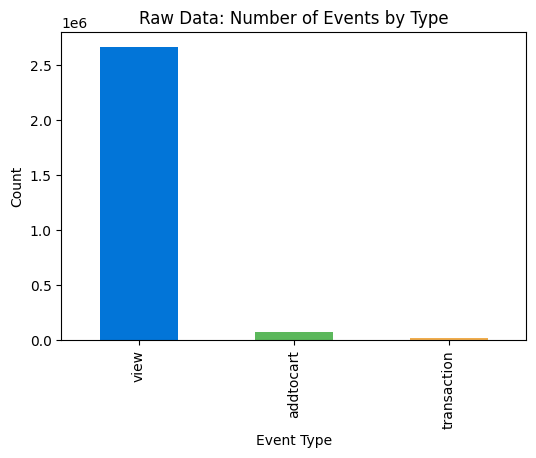

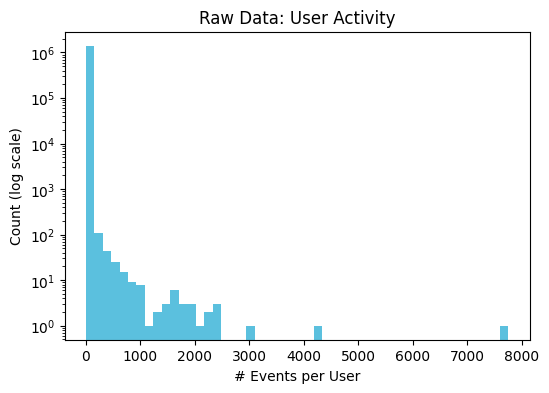

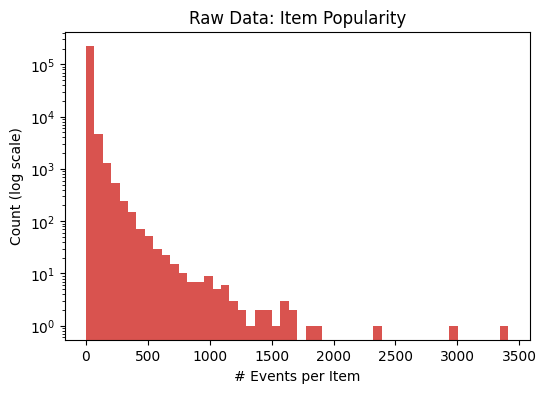

In [2]:
# Import necessary libraries
# pandas: Used for working with tabular data (like Excel).
# numpy: Used for high-performance numerical operations.
# scikit-learn: Provides simple data processing tools.
# matplotlib: Used for plotting graphs and visualizing data.
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load data from the events.csv file. This file contains user behavior logs.
events = pd.read_csv('events.csv')
raw_events = events.copy() # Create a copy for before-and-after comparison

# Function to plot a bar chart for event types (view, addtocart, transaction)
def plot_event_type_bar(df, title):
    plt.figure(figsize=(6,4))
    df['event'].value_counts().plot(kind='bar', color=['#0275d8','#5cb85c','#f0ad4e'])
    plt.title(title)
    plt.xlabel("Event Type")
    plt.ylabel("Count")
    plt.show()

# Function to plot a histogram by group to see data distribution
def plot_hist_by_group(df, group_col, title, xlabel, color):
    plt.figure(figsize=(6,4))
    # Data is grouped and plotted as a histogram. A log scale is used to make large value differences more visible.
    df.groupby(group_col).size().plot(kind='hist', bins=50, log=True, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count (log scale)")
    plt.show()

# Print the raw data shape and plot initial statistical charts
print(f"Raw data shape: {raw_events.shape}")
plot_event_type_bar(raw_events, "Raw Data: Number of Events by Type")
plot_hist_by_group(raw_events, 'visitorid', "Raw Data: User Activity", "# Events per User", '#5bc0de')
plot_hist_by_group(raw_events, 'itemid', "Raw Data: Item Popularity", "# Events per Item", '#d9534f')

## 2. Data Cleaning & Feature Engineering

In [3]:
# --- Code Explanation: Why these steps? ---
# The goal of this section is to transform raw event logs into a clean, structured dataset suitable for training a recommendation model.
# Just like a chef needs to prepare clean ingredients before cooking, we need "clean" data for the AI model to perform well.

# Remove duplicate event logs to prevent single interactions from being overweighted.
events = events.drop_duplicates()

# Convert Unix timestamp (a long number representing time) to a more readable datetime format.
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')

# Remove bots (automated programs, not real users).
# Here, we assume that if a "user" generates more than 200 events in an hour, it is likely a bot.
user_hour = events.groupby(['visitorid', pd.Grouper(key='datetime', freq='h')]).size().reset_index(name='event_count')
bots = user_hour[user_hour['event_count'] > 200]['visitorid'].unique()
events = events[~events['visitorid'].isin(bots)]

# Filter out users and items with too few interactions (less than 5).
# This helps the model focus on more meaningful data, avoiding noise from single, random interactions.
active_users = events['visitorid'].value_counts()[lambda x: x >= 5].index
active_items = events['itemid'].value_counts()[lambda x: x >= 5].index
events = events[events['visitorid'].isin(active_users) & events['itemid'].isin(active_items)]

# --- Sessionization: Grouping events into user sessions ---
# A session is a series of user actions during a single visit.
# We define a new session to begin if the user is inactive for 30 minutes. This is a common industry standard.
events = events.sort_values(['visitorid', 'datetime'])
events['session_id_num'] = (events.groupby('visitorid')['datetime']
    .diff().gt(timedelta(minutes=30)).cumsum().astype(int))
events['session_id'] = events['visitorid'].astype(str) + '_' + events['session_id_num'].astype(str)

# --- Feature Engineering: Adding more predictive signals ---
# We create new information from the original data to help the model "understand" users and items better.

# Product popularity features: Count how many times an item was viewed, added to cart, and purchased.
# This is a very important signal indicating an item's appeal.
pop_counts = events.groupby(['itemid', 'event']).size().unstack(fill_value=0)
events['item_view_count'] = events['itemid'].map(pop_counts.get('view', pd.Series()))
events['item_addtocart_count'] = events['itemid'].map(pop_counts.get('addtocart', pd.Series()))
events['item_transaction_count'] = events['itemid'].map(pop_counts.get('transaction', pd.Series()))

# User profile features: Summarize a user's past behavior.
user_total_sessions = events.groupby('visitorid')['session_id'].nunique()
events['user_total_sessions'] = events['visitorid'].map(user_total_sessions)
user_total_purchases = events[events['event'] == 'transaction'].groupby('visitorid').size()
events['user_total_purchases'] = events['visitorid'].map(user_total_purchases).fillna(0)
if 'categoryid' in events.columns:
    def preferred_categories(x):
        return pd.Series(x).value_counts().index[:3].tolist()
    user_pref_cats = events.groupby('visitorid')['categoryid'].apply(preferred_categories)
    events['user_preferred_categories'] = events['visitorid'].map(user_pref_cats)
else:
    events['user_preferred_categories'] = None


# Time-based features: Help the model recognize trends by day of the week or hour of the day.
events['day_of_week'] = events['datetime'].dt.dayofweek
events['hour_of_day'] = events['datetime'].dt.hour

# Event weighting: The "transaction" action is more important than "view".
# We assign a number (weight) to represent this importance for the model.
event_map = {'view': 1, 'addtocart': 3, 'transaction': 5}
events['event_weight'] = events['event'].map(event_map)

# ID Encoding: AI models work better with continuous integers (0, 1, 2,...) instead of long string IDs.
# LabelEncoder is like assigning a unique number to each user/item.
user_enc = LabelEncoder()
item_enc = LabelEncoder()
session_enc = LabelEncoder()
events['user_idx'] = user_enc.fit_transform(events['visitorid'])
events['item_idx'] = item_enc.fit_transform(events['itemid'])
events['session_idx'] = session_enc.fit_transform(events['session_id'])

# Session features: Provide context about the duration and density of a session.
session_info = events.groupby('session_id').agg(
    session_start=('datetime', 'min'),
    session_end=('datetime', 'max'),
    events_per_session=('event', 'count')
)
session_info['session_duration'] = (session_info['session_end'] - session_info['session_start']).dt.total_seconds()
events['session_duration'] = events['session_id'].map(session_info['session_duration'])
events['events_per_session'] = events['session_id'].map(session_info['events_per_session'])

## 3. Statistics After Cleaning

Cleaned data shape: (895965, 22)


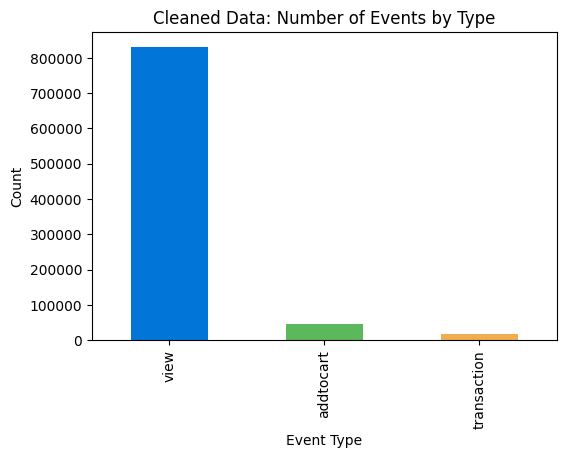

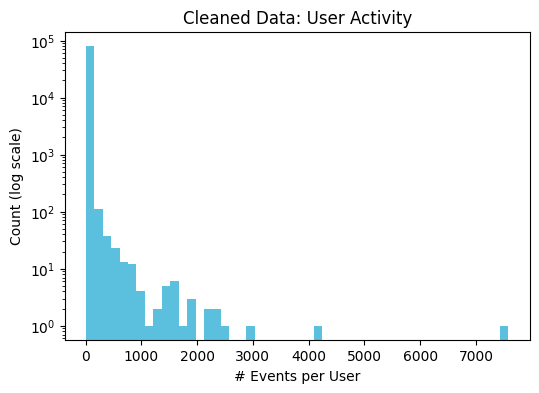

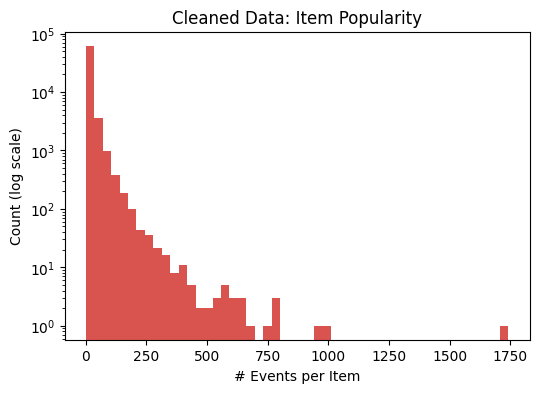

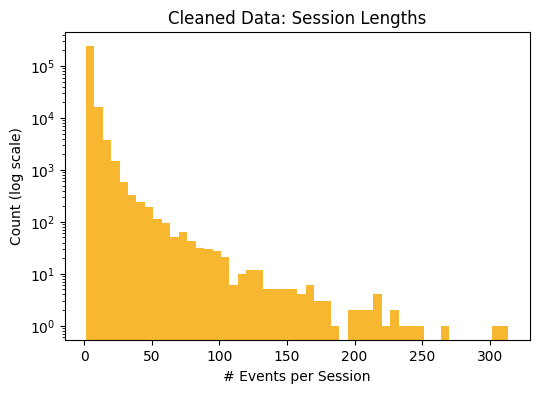

In [4]:
print(f"Cleaned data shape: {events.shape}")
plot_event_type_bar(events, "Cleaned Data: Number of Events by Type")
plot_hist_by_group(events, 'visitorid', "Cleaned Data: User Activity", "# Events per User", '#5bc0de')
plot_hist_by_group(events, 'itemid', "Cleaned Data: Item Popularity", "# Events per Item", '#d9534f')
plot_hist_by_group(events, 'session_id', "Cleaned Data: Session Lengths", "# Events per Session", '#f7b731')

## 4. Data Split (Temporal)

In [5]:
# We split the data into 3 parts: train, validation, and test.
# - train: Data to "teach" the model.
# - validation: Data to "tune" the model's settings.
# - test: Data for the "final exam," to evaluate the model's final performance.
# Splitting by time (older data for training, newer data for testing) is crucial to correctly simulate a real-world scenario.
max_date = events['datetime'].max()
train_cutoff = max_date - timedelta(weeks=2)
val_cutoff = max_date - timedelta(weeks=1)

train = events[events['datetime'] < train_cutoff]
valid = events[(events['datetime'] >= train_cutoff) & (events['datetime'] < val_cutoff)]
test = events[events['datetime'] >= val_cutoff]

## 5. Most Popular Model (Baseline)

In [6]:
# This is the simplest, non-personalized model.
# It simply recommends the items that were most interacted with in the past.
# We use it as a "minimum performance level" to compare against more complex models.
most_popular = train['item_idx'].value_counts().index[:20].tolist()

## 6. SVD Collaborative Filtering Model (with Surprise library)

### Explanation of Collaborative Filtering and the `Surprise` library

**Collaborative Filtering** is a popular technique. The core idea is: if user A and user B liked similar items in the past, it's highly likely that A will also like a new item that B liked.

We will use the **`Surprise`** library, a very popular and powerful Python library specialized for building recommendation systems. It's easy to install and use. We'll use the **SVD (Singular Value Decomposition)** algorithm, a matrix factorization technique similar to ALS that performs very well.

In [7]:
# Alternative Solution: Using the Surprise library (SVD)
# This library is easy to install and efficient for recommendation tasks on a single machine.
from surprise import Dataset, Reader, SVD
from collections import defaultdict

svd_model = None
try:
    # 1. Prepare data for the Surprise library
    # Surprise requires data in a specific format (user, item, rating).
    # We need to define a 'Reader' to specify the rating scale (e.g., from 1 to 5 for event_weight).
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(train[['user_idx', 'item_idx', 'event_weight']], reader)
    
    # Build the training set from all loaded data
    trainset = data.build_full_trainset()
    
    # 2. Initialize and train the SVD model
    # n_factors: The number of latent factors (similar to 'rank' in ALS).
    # n_epochs: The number of iterations over the data for learning.
    svd_model = SVD(n_factors=50, n_epochs=20, random_state=42, verbose=True)
    
    # Train the model (usually quite fast)
    svd_model.fit(trainset)
    
    print("--- SVD model training with Surprise library complete. ---")

except Exception as e:
    print(f"--- Could not train SVD model with Surprise: {e} ---")
    svd_model = None

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--- SVD model training with Surprise library complete. ---


## 7. GRU4Rec Model (PyTorch, Demo Version)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# --- Explanation of AI Concepts ---
# Dataset: Like a photo album, it organizes our training data. Each "photo" is a learning example (a piece of a session and the next item).
# DataLoader: Like a conveyor belt, it feeds the "photos" (data) to the model in small, manageable batches.
class SessionDataset(Dataset):
    def __init__(self, seqs, maxlen=10):
        self.samples = []
        # Create (input, output) pairs from each session
        # Example: session [A, B, C] -> creates ( [A], B ) and ( [A, B], C )
        for seq in seqs:
            for i in range(1, len(seq)):
                start = max(0, i - maxlen)
                self.samples.append((seq[start:i], seq[i]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        seq, label = self.samples[idx]
        # Ensure each input sequence has the same length by padding with zeros
        x = np.zeros(10, dtype=int)
        x[-len(seq):] = seq[-10:]
        return torch.LongTensor(x), torch.LongTensor([label])

# --- Explanation of GRU4Rec Model Architecture ---
# nn.Module: The basic blueprint for any "brain" (model) in PyTorch.
# nn.Embedding: A smart "lookup table" that learns a rich description for each item. Instead of just a number, each item gets a "feature vector" representing its "personality."
# nn.GRU: The "memory" of the model. It reads the sequence of items a user has seen and tries to remember the pattern to predict the next item.
# nn.Linear: The "decision-making" part. After the GRU understands the session, this layer makes the final prediction across all items.
class GRU4Rec(nn.Module):
    def __init__(self, n_items, emb_dim=50, hid_dim=100):
        super().__init__()
        self.embedding = nn.Embedding(n_items, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim, n_items)
    def forward(self, x):
        emb = self.embedding(x)
        _, h = self.gru(emb)
        out = self.fc(h.squeeze(0))
        return out

# Prepare sequence data for training
seq_df = (train.groupby('session_id')['item_idx'].apply(list).reset_index(name='seq'))
seq_df = seq_df[seq_df['seq'].apply(lambda x: len(x) > 1)]
sequences = seq_df['seq'].tolist()

dataset = SessionDataset(sequences)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Select the device for training (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 8. Hyperparameter Tuning (Demonstration)

In [9]:
# As mentioned in the report (section 4.2), we use the validation set to tune hyperparameters.
# This process helps find the best model configuration (e.g., learning rate, model complexity) without touching the final test set.
# NOTE: A full hyperparameter search can be time-consuming. This code demonstrates the process with a limited search space.

def evaluate_model(model, val_sequences, k=20):
    """Calculates recall@k on the validation set."""
    model.eval()
    recalls = []
    with torch.no_grad():
        for seq in val_sequences:
            if len(seq) < 2: continue
            input_seq = torch.LongTensor([seq[:-1][-10:]]).to(device)
            target = seq[-1]
            logits = model(input_seq)
            topk = logits.cpu().numpy().argsort()[0][-k:][::-1]
            if target in topk:
                recalls.append(1)
            else:
                recalls.append(0)
    return np.mean(recalls)

# Prepare validation sequences
val_seq_df = (valid.groupby('session_id')['item_idx'].apply(list).reset_index(name='seq'))
val_sequences = val_seq_df['seq'].tolist()

# Hyperparameter search space (example)
learning_rates = [0.001, 0.005]
embedding_dims = [50, 100]
hidden_dims = [100, 150]
best_recall = -1
best_params = {}

print("--- Starting Hyperparameter Tuning for GRU4Rec ---")
for lr in learning_rates:
    for emb_dim in embedding_dims:
        for hid_dim in hidden_dims:
            print(f"Tuning with: lr={lr}, emb_dim={emb_dim}, hid_dim={hid_dim}")
            
            # Initialize and train the model with current params
            current_model = GRU4Rec(n_items=events['item_idx'].nunique(), emb_dim=emb_dim, hid_dim=hid_dim).to(device)
            optimizer = torch.optim.Adam(current_model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()

            # Abridged training loop for tuning
            for epoch in range(2): # Use fewer epochs for faster tuning
                current_model.train()
                for xb, yb in loader:
                    xb, yb = xb.to(device), yb.to(device).squeeze()
                    optimizer.zero_grad()
                    logits = current_model(xb)
                    loss = loss_fn(logits, yb)
                    loss.backward()
                    optimizer.step()
            
            # Evaluate on validation set
            recall = evaluate_model(current_model, val_sequences)
            print(f"Validation Recall@20: {recall:.4f}")
            
            if recall > best_recall:
                best_recall = recall
                best_params = {'lr': lr, 'emb_dim': emb_dim, 'hid_dim': hid_dim, 'recall': recall}

print(f"--- Tuning Complete ---")
print(f"Best Params Found: {best_params}")

--- Starting Hyperparameter Tuning for GRU4Rec ---
Tuning with: lr=0.001, emb_dim=50, hid_dim=100
Validation Recall@20: 0.2747
Tuning with: lr=0.001, emb_dim=50, hid_dim=150
Validation Recall@20: 0.3014
Tuning with: lr=0.001, emb_dim=100, hid_dim=100
Validation Recall@20: 0.2997
Tuning with: lr=0.001, emb_dim=100, hid_dim=150
Validation Recall@20: 0.3332
Tuning with: lr=0.005, emb_dim=50, hid_dim=100
Validation Recall@20: 0.3380
Tuning with: lr=0.005, emb_dim=50, hid_dim=150
Validation Recall@20: 0.3328
Tuning with: lr=0.005, emb_dim=100, hid_dim=100
Validation Recall@20: 0.3380
Tuning with: lr=0.005, emb_dim=100, hid_dim=150
Validation Recall@20: 0.3327
--- Tuning Complete ---
Best Params Found: {'lr': 0.005, 'emb_dim': 50, 'hid_dim': 100, 'recall': 0.33801404212637914}


## 8a. Visualizing the Effect of Hyperparameter Tuning

--- Evaluating model with default parameters for comparison ---
Default Params Validation Recall@20: 0.2780


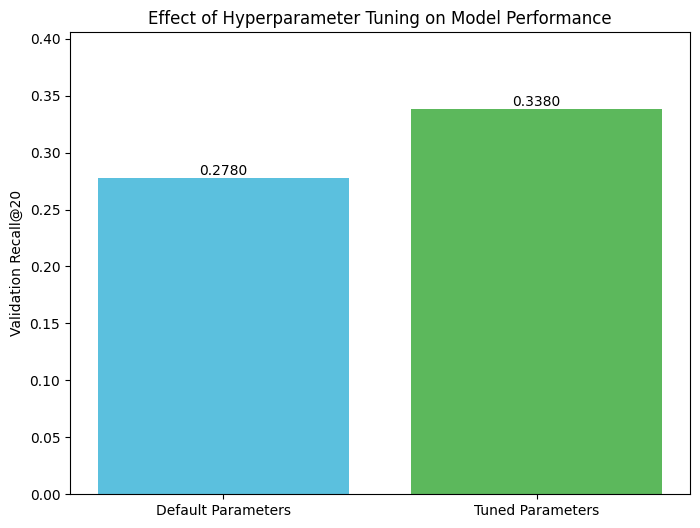

In [10]:
# This section demonstrates the impact of the tuning process by comparing the validation recall
# of the model trained with default parameters against the model trained with the best parameters found.

# --- Step 1: Evaluate the model with default parameters ---
print("--- Evaluating model with default parameters for comparison ---")
default_params = {'lr': 0.001, 'emb_dim': 50, 'hid_dim': 100}
default_model = GRU4Rec(
    n_items=events['item_idx'].nunique(),
    emb_dim=default_params['emb_dim'],
    hid_dim=default_params['hid_dim']
).to(device)
optimizer = torch.optim.Adam(default_model.parameters(), lr=default_params['lr'])
loss_fn = nn.CrossEntropyLoss()

# Train with default params for 2 epochs (to match the tuning loop)
for epoch in range(2):
    default_model.train()
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device).squeeze()
        optimizer.zero_grad()
        logits = default_model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()

default_recall = evaluate_model(default_model, val_sequences)
print(f"Default Params Validation Recall@20: {default_recall:.4f}")

# --- Step 2: Prepare data for plotting ---
tuned_recall = best_params.get('recall', 0) # Get recall from the tuning results
labels = ['Default Parameters', 'Tuned Parameters']
recall_values = [default_recall, tuned_recall]

# --- Step 3: Create and display the bar chart ---
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, recall_values, color=['#5bc0de', '#5cb85c'])
plt.ylabel('Validation Recall@20')
plt.title('Effect of Hyperparameter Tuning on Model Performance')
plt.ylim(0, max(recall_values) * 1.2) # Set y-axis limit to be 20% higher than the max recall

# Add recall values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.show()

## 9. Final GRU4Rec Model Training

In [11]:
# Now we train the final model using the best hyperparameters found during tuning.
# If tuning was skipped, we use default parameters.
final_params = best_params if best_params else {'lr': 0.001, 'emb_dim': 50, 'hid_dim': 100}

model = GRU4Rec(
    n_items=events['item_idx'].nunique(),
    emb_dim=final_params['emb_dim'],
    hid_dim=final_params['hid_dim']
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=final_params['lr'])
loss_fn = nn.CrossEntropyLoss()

print("\n--- Training Final Model with Best Parameters ---")
# --- Explanation of the Training Process ---
# Imagine you are teaching a student (the model) to guess the next item.
# 1. `logits = model(xb)`: The student makes a prediction.
# 2. `loss = loss_fn(logits, yb)`: We calculate how "wrong" the prediction was. This is the "score" on their test. A higher score is worse.
# 3. `loss.backward()`: We figure out *why* the prediction was wrong and which parts of the student's "brain" need adjustment.
# 4. `optimizer.step()`: We make the actual adjustments to the student's "brain" so they will do better on the next prediction.
# This "predict, check score, adjust" process is repeated thousands of times.
for epoch in range(20): # Train for more epochs if needed
    model.train()
    epoch_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device).squeeze()
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(loader):.4f}")


--- Training Final Model with Best Parameters ---
Epoch 1, Loss: 8.1840
Epoch 2, Loss: 5.4080
Epoch 3, Loss: 4.4099
Epoch 4, Loss: 3.8710
Epoch 5, Loss: 3.5101
Epoch 6, Loss: 3.2346
Epoch 7, Loss: 3.0137
Epoch 8, Loss: 2.8349
Epoch 9, Loss: 2.6825
Epoch 10, Loss: 2.5550
Epoch 11, Loss: 2.4493
Epoch 12, Loss: 2.3531
Epoch 13, Loss: 2.2762
Epoch 14, Loss: 2.2070
Epoch 15, Loss: 2.1425
Epoch 16, Loss: 2.0933
Epoch 17, Loss: 2.0483
Epoch 18, Loss: 2.0066
Epoch 19, Loss: 1.9690
Epoch 20, Loss: 1.9383


## 10. Model Performance Table (Section 4.3)

In [12]:
# This section generates the final performance metrics on the unseen test set.

# --- Explanation of Evaluation Metrics ---
# Precision@k: Out of the k items we recommended, what percentage were correct? It measures the *relevance* of the recommendations.
# Recall@k: In this problem (predicting the next item), it's identical to Precision@k because there's only one correct item. It asks: "Did we find the correct item in our top K suggestions?"
# NDCG@k: A smarter version of precision. It gives a higher score if the correct item is at position #1 than at position #20. It rewards correct ranking.

def precision_at_k(y_true, y_pred, k=20):
    hits = 0; total = 0
    for pred, true in zip(y_pred, y_true):
        if true in pred[:k]: hits += 1
        total += 1
    return hits / total if total > 0 else 0

def recall_at_k(y_true, y_pred, k=20): return precision_at_k(y_true, y_pred, k)
def f1_at_k(y_true, y_pred, k=20): p = precision_at_k(y_true, y_pred, k); r = recall_at_k(y_true, y_pred, k); return 2*p*r/(p+r+1e-10)

def ndcg_at_k(y_true, y_pred, k=20):
    ndcg = 0
    for pred, true in zip(y_pred, y_true):
        if true in pred[:k]:
            idx = pred[:k].index(true)
            ndcg += 1 / np.log2(idx + 2)
    return ndcg / len(y_true) if len(y_true) > 0 else 0

# --- Prepare data and predictions from models ---
test_sessions_df = test.groupby('session_id').agg(item_idxs=('item_idx', list), user_idx=('user_idx', 'first')).reset_index()
test_sessions_df = test_sessions_df[test_sessions_df['item_idxs'].apply(len) > 1]

y_true = test_sessions_df['item_idxs'].apply(lambda x: x[-1]).tolist()
test_session_inputs = test_sessions_df['item_idxs'].apply(lambda x: x[:-1]).tolist()

# Predictions from Most Popular
y_pred_pop = [most_popular for _ in y_true]


# Predictions from GRU4Rec (already utilizes GPU if available)
def predict_next_gru(model, session, k=20):
    model.eval()
    with torch.no_grad():
        inp = torch.LongTensor([session[-10:]]).to(device) # .to(device) moves the tensor to the GPU
        logits = model(inp)
        topk = logits.cpu().numpy().argsort()[0][-k:][::-1]
    return topk.tolist()
y_pred_gru = [predict_next_gru(model, session_input, k=20) for session_input in test_session_inputs]

# --- Create results table ---
results = []
results.append(['Most Popular', None, precision_at_k(y_true, y_pred_pop, 20), recall_at_k(y_true, y_pred_pop, 20), f1_at_k(y_true, y_pred_pop, 20), ndcg_at_k(y_true, y_pred_pop, 20)])
results.append(['GRU4Rec (Tuned)', None, precision_at_k(y_true, y_pred_gru, 20), recall_at_k(y_true, y_pred_gru, 20), f1_at_k(y_true, y_pred_gru, 20), ndcg_at_k(y_true, y_pred_gru, 20)])

# Get predictions from the SVD model if it was successfully trained
# *** THIS PART IS OPTIMIZED TO AVOID MEMORY OVERFLOW ***
if svd_model is not None:
    print("\n--- Getting predictions from SVD model (memory-optimized version) ---")
    svd_user2pred = {}
    all_item_idxs = train['item_idx'].unique()
    test_user_idxs = test_sessions_df['user_idx'].unique()

    # Efficiently loop through each user in the test set
    for user_idx in test_user_idxs:
        # Get the list of items the user has interacted with in the training set
        interacted_items = train[train['user_idx'] == user_idx]['item_idx'].unique()
        
        # Get the list of items the user has NOT interacted with to predict
        items_to_predict = np.setdiff1d(all_item_idxs, interacted_items)
        
        # Predict scores for the unseen items for ONLY this user
        predictions = [svd_model.predict(user_idx, item_idx) for item_idx in items_to_predict]
        
        # Sort and get top 20
        predictions.sort(key=lambda x: x.est, reverse=True)
        svd_user2pred[user_idx] = [pred.iid for pred in predictions[:20]]

    # Map the calculated recommendations to the correct order of test sessions
    y_pred_svd = [svd_user2pred.get(uidx, most_popular) for uidx in test_sessions_df['user_idx']]
    
    results.append(['SVD (Surprise)', None, precision_at_k(y_true, y_pred_svd, 20), recall_at_k(y_true, y_pred_svd, 20), f1_at_k(y_true, y_pred_svd, 20), ndcg_at_k(y_true, y_pred_svd, 20)])

# Display the final results DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision@20', 'Recall@20', 'F1@20', 'NDCG@20'])
print("\n--- Model Performance Comparison Table ---")
display(results_df)


--- Getting predictions from SVD model (memory-optimized version) ---

--- Model Performance Comparison Table ---


,Model,Accuracy,Precision@20,Recall@20,F1@20,NDCG@20
0,Most Popular,None,0.017294,0.017294,0.017294,0.008429
1,GRU4Rec (Tuned),None,0.220549,0.220549,0.220549,0.123004
2,SVD (Surprise),None,0.001424,0.001424,0.001424,0.000335


## 11. Product Recommendation Functions (with Probabilities/Scores)

In [18]:
# This function takes a user's session, passes it through the GRU4Rec model, and returns the top N recommended items.
# F.softmax: A mathematical function that converts the model's raw output scores into probabilities (numbers from 0 to 1 that sum to 1).
def recommend_products_gru4rec_with_probs(model, session_items, n=5):
    model.eval()
    with torch.no_grad():
        inp = torch.LongTensor([session_items[-10:]]).to(device)
        logits = model(inp)
        probs = F.softmax(logits, dim=1).cpu().numpy().flatten()
        top_idx = probs.argsort()[-n:][::-1]
        top_probs = probs[top_idx]
        # Convert integer indices back to original item IDs for display
        top_items = item_enc.inverse_transform(top_idx)
    return list(zip(top_items, top_probs))

# This function returns the top N most popular items, used for the baseline model.
def recommend_most_popular_with_probs(n=5):
    pop_counts = train['item_idx'].value_counts()
    total = pop_counts.sum()
    top_idx = pop_counts.index[:n]
    top_probs = pop_counts.iloc[:n] / total
    top_items = item_enc.inverse_transform(top_idx)
    return list(zip(top_items, top_probs))

# Recommendation function for the SVD (Surprise) model
def recommend_products_svd(model, user_idx, trainset, n=5):
    if model is None:
        return []
    
    # Get the list of items the user has not interacted with
    user_inner_id = trainset.to_inner_uid(user_idx)
    user_items = trainset.ur[user_inner_id]
    item_indices_interacted = [item_id for item_id, rating in user_items]
    
    all_item_indices = range(trainset.n_items)
    items_to_predict = np.setdiff1d(all_item_indices, item_indices_interacted)
    
    # Predict and sort
    predictions = [model.predict(user_idx, trainset.to_raw_iid(item_inner_id)) for item_inner_id in items_to_predict]
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Get top N
    top_n_preds = predictions[:n]
    top_items_idx = [pred.iid for pred in top_n_preds]
    top_scores = [pred.est for pred in top_n_preds]
    top_items = item_enc.inverse_transform(top_items_idx)
    
    return list(zip(top_items, top_scores))

## 12. User-Friendly Demo (Enhanced)

In [33]:
# Get a random session from the test set with at least 4 items for the demo
test_sessions_df_demo = test.groupby('session_id')['itemid'].apply(list).reset_index()
valid_sessions = test_sessions_df_demo[test_sessions_df_demo['itemid'].apply(lambda x: len(x) >= 4)]
random_row = valid_sessions.sample(n=1, random_state=42)
session_items = random_row['itemid'].iloc[0]
input_items = session_items[:-1] # Items the user has viewed
ground_truth = session_items[-1] # The actual next item the user viewed
example_session_gru = item_enc.transform(input_items) # Convert item IDs to integer indices for GRU4Rec
user_display = test[test['session_id'] == random_row['session_id'].iloc[0]]['visitorid'].iloc[0]
user_display_idx = user_enc.transform([user_display])[0] # Get the index for SVD

print(f"\n👤 User {user_display}'s recent items: ", ', '.join(str(x) for x in input_items))
print(f"✅ Actual next item (ground truth): {ground_truth}\n")

# --- Enhanced Demo: Comparing different models ---

# Personalized recommendations from GRU4Rec (based on the most recent sequence of behavior)
print(f"Top 5 Recommendations for user {user_display} (Personalized by session - GRU4Rec):")
for item, prob in recommend_products_gru4rec_with_probs(model, example_session_gru, n=5):
    print(f"Item {item}, Probability={prob:.4f}")

# Personalized recommendations from SVD (based on the user's entire history)
if svd_model is not None and 'trainset' in locals():
    # --- IMPORTANT CHANGE: Use try-except to check if the user is in the trainset ---
    try:
        # Try to convert the ID. If successful, the user exists in the training set.
        trainset.to_inner_uid(user_display_idx)
        
        svd_recs = recommend_products_svd(svd_model, user_display_idx, trainset, n=5)
        if svd_recs:
            print(f"\nTop 5 Recommendations for user {user_display} (Personalized by history - SVD):")
            for item, score in svd_recs:
                print(f"Item {item}, Predicted Score={score:.4f}")
    except ValueError:
        # If to_inner_uid raises a ValueError, the user is not in the training set.
        print(f"\nUser {user_display} is a new user and not in the SVD model's training set.")
        print("(SVD cannot provide personalized recommendations for this new user).")


# Non-Personalized recommendations from "Most Popular"
print(f"\nTop 5 Recommendations for user {user_display} (Non-Personalized - Most Popular):")
for item, prob in recommend_most_popular_with_probs(n=5):
    print(f"Item {item}, Popularity Score (normalized)={prob:.4f}")


👤 User 1318877's recent items:  49635, 49635, 56640, 138672, 49635
✅ Actual next item (ground truth): 49635

Top 5 Recommendations for user 1318877 (Personalized by session - GRU4Rec):
Item 212382, Probability=0.1742
Item 188158, Probability=0.1114
Item 385148, Probability=0.0445
Item 363109, Probability=0.0360
Item 416697, Probability=0.0324

User 1318877 is a new user and not in the SVD model's training set.
(SVD cannot provide personalized recommendations for this new user).

Top 5 Recommendations for user 1318877 (Non-Personalized - Most Popular):
Item 461686, Popularity Score (normalized)=0.0017
Item 257040, Popularity Score (normalized)=0.0012
Item 9877, Popularity Score (normalized)=0.0010
Item 309778, Popularity Score (normalized)=0.0010
Item 119736, Popularity Score (normalized)=0.0009
